## Place Cell Analysis 

In [2]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from scipy import signal
from spiketools.plts.trials import plot_rasters
from convnwb.io import make_session_name

from spiketools.spatial.information import compute_spatial_information
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.utils import make_axes, make_grid, get_grid_subplot
from spiketools.plts.spatial import plot_heatmap, create_heatmap_title
from spiketools.plts.annotate import add_vlines, color_pvalue

from spiketools.plts.style import drop_spines
from spiketools.plts.stats import plot_surrogates
from spiketools.utils.run import create_methods_list

In [3]:
import sys
sys.path.append('../code')
from models import create_df_place, fit_anova_place
from utils import  compute_firing_rates, compute_trial_firing_rates, compute_t_occupancy, circular_shuffle_unit_fr
sys.path.append('../scripts')
from settings import METHODS, SURROGATES

In [4]:

from scipy.io import loadmat
data = loadmat('/Users/weijiazhang/Data/Train/data_matfile/R1219C_0_train_events.mat')
behavioral_data = pd.read_csv('/Users/weijiazhang/Data/Train/events/events.csv')

## Settings 

In [5]:
epochSize = 0.1
numBins = 40
kernelSize = 8
numBinsSpeed = 25
units = 19

In [6]:
session = {
    'experiment' : 'TRAIN',
    'subject' : 'R1219C',
    'session' : '0'    
}

experiment = session['experiment']
subject = session['subject']
sess = session['session']
session_name = make_session_name(subject,experiment,sess)
session_name

'TRAIN_R1219C_session_0'

## Load Neural Data 

In [7]:
events_fr = data['events']['fr'][0][0]
events_fr.shape

(7654, 23)

## Load Behavioral Data 

In [8]:
# Get behavioral data
df = pd.DataFrame(data['events']['events'][0][0][0])
# Convert object columns to string type
str_cols = ['subj', 'object','timesfile']
for col in str_cols:
    df[col] = df[col].str[0].astype(str)
# Convert numeric columns to appropriate types
int_cols = ['session', 'trialNum', 'blockType', 'driveType'] 
float_cols = ['object_position', 'response_position', 'response_mstime', 'timesoffset','mstime', 'position','speed']
for col in int_cols:
    df[col] = df[col].str[0].astype(int)
for col in float_cols:
    df[col] = df[col].str[0].astype(float)

behavioral_data = df

## Load Spiking Data

In [9]:
spike_times = data['events']['spikeData'][0][0]['spikeTimes'][0][0][0][units]
spike_index = np.arange(len(spike_times), dtype=np.uint32)+1

In [10]:
time_offset = df['timesoffset']
right_edges = time_offset + 99

In [ ]:
mstime = df['timesoffset']

# Initialize dictionaries to store spikes in each bin and their indices
spikes_in_bin = []
spike_index_within_bin = {}

# Loop through each time bin
            # Loop through each time bin
for k in range(len(mstime)):
    # Find spikes that fall within the current time bin
    mask = (spike_times >= mstime[k]) & (spike_times <= right_edges[k])
    spike_indices = np.where(mask)[0]
    if len(spike_indices) > 0:
        #spikes_in_bin.append(spike_index[spike_indices])
        spikes_in_bin.append(spike_indices)
    else:
        spikes_in_bin.append(0)


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[85]
[]
[]
[]
[86]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[87]
[]
[]
[88]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[89]
[]
[]
[]
[]
[90]
[]
[]
[]
[91]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[92]
[]
[93]
[]
[94]
[]
[]
[95]
[]
[96]
[]
[]
[]
[]
[]
[]
[]
[]
[104]
[]
[]
[105]
[]
[]
[]
[106]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[107]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[108]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[109]
[]
[]
[]
[]
[110]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[111]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[112]
[]
[]
[]
[]
[113]
[]
[]
[]
[]
[]
[]
[114]
[]
[]
[]
[]
[]
[]
[]
[115]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[131]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[132]
[133]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

In [12]:
# # Drop the spikes_in_bin entries for bad trials (where speed < 2)
# spikes_in_bin = [spikes_in_bin[i] for i in range(len(spikes_in_bin)) if not bad[i]]




In [13]:
len(spikes_in_bin)

7654

In [14]:
# spike_position = np.zeros(len(positions))

# for k in range(len(spikes_in_bin)):
#     if isinstance(spikes_in_bin[k], np.ndarray) and spikes_in_bin[k].size > 0:
#         spike_position[k] = positions[k]
#     else:
#         spike_position[k] = 0

## Spike Name

In [15]:
spike_name = data['events']['spikeData'][0][0]['spikeNames'][0][0][0][units]
print(f"Spike name: {spike_name}")


Spike name: ['NSX124_2']


## Speed

In [16]:
speeds = np.array(behavioral_data['speed'])
bad = speeds < 2

In [17]:
# behavioral_data = behavioral_data[~bad]
# events_fr = events_fr[~bad,:]

## Unit Data

In [18]:
units_fr = events_fr[:,units]

In [19]:
type(events_fr)

numpy.ndarray

## Extract Position Data

In [20]:
positions = behavioral_data['position']
positions = (positions + 34) / 68  # Normalize to 0-1 range
positions[positions < 0] = 0  # Clip values below 0
positions[positions > 1] = 1 
positions 

0       0.000439
1       0.002422
2       0.006106
3       0.011512
4       0.018584
          ...   
7649    0.930124
7650    0.942914
7651    0.954228
7652    0.964259
7653    0.973158
Name: position, Length: 7654, dtype: float64

In [21]:
len(positions)

7654

In [22]:
spike_position = np.zeros(len(positions))

for k in range(len(spikes_in_bin)):
    if isinstance(spikes_in_bin[k], np.ndarray) and spikes_in_bin[k].size > 0:
        spike_position[k] = positions[k]
    else:
        spike_position[k] = 0


In [23]:
spike_position[spike_position < .01] = np.nan

In [24]:
spike_position

array([nan, nan, nan, ..., nan, nan, nan])

Text(0.5, 1.0, 'Position Over Time with Spike Positions')

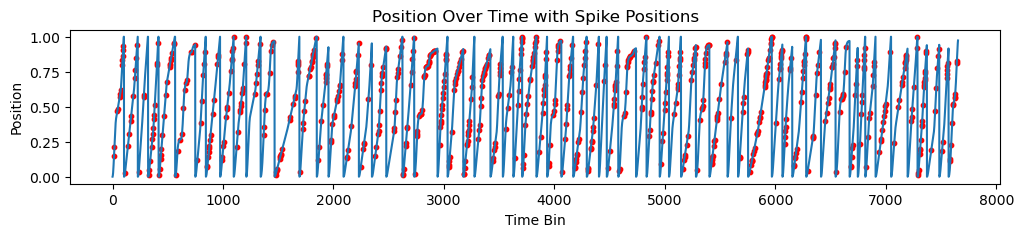

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.plot(positions)
ax.scatter(range(len(spike_position)), spike_position,color = 'red', s=10)
plt.xlabel('Time Bin')
plt.ylabel('Position')
plt.title('Position Over Time with Spike Positions')

In [26]:
trialNum = behavioral_data['trialNum']
# Find where trial numbers change
trial_changes = np.where(np.diff(np.concatenate(([1], trialNum.values))))[0]

Text(0.5, 0, 'Position')

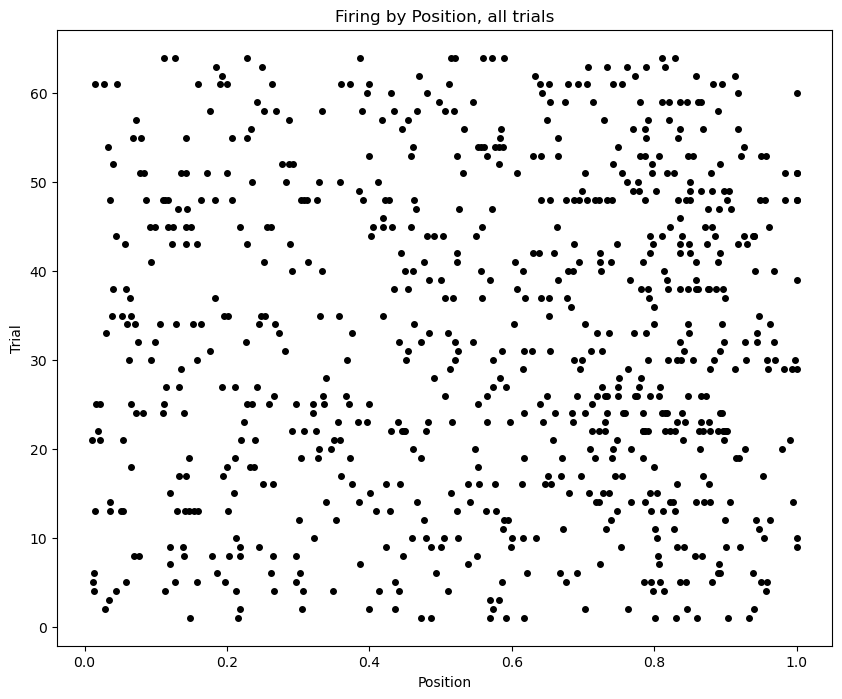

In [27]:
spikes_positions_trials = [[] for _ in range(64)]

# Create a figure
plt.figure(figsize=(10, 8))

# For each trial
for num_trial in range(64):
    # Define trial indices
    trial_idx = [0, *trial_changes, len(spike_position)]
    
    # Extract spike positions for this trial
    if num_trial < len(trial_idx) - 1:
        trial_start = trial_idx[num_trial]
        trial_end = trial_idx[num_trial + 1]
        spikes_positions_trials[num_trial] = spike_position[trial_start:trial_end]
        
        # Plot spike positions for this trial
        if len(spikes_positions_trials[num_trial]) > 0:
            plt.plot(spikes_positions_trials[num_trial], 
                     [num_trial + 1] * len(spikes_positions_trials[num_trial]), 
                     'k.', markersize=8)

# Add labels and title
plt.title('Firing by Position, all trials')
plt.ylabel('Trial')
plt.xlabel('Position')

## Bin Positions into Percentage Along The Track

In [28]:
edges_pos = np.linspace(0, 100, numBins+1)
pos_bin = np.digitize(positions*100, edges_pos)
count, _ = np.histogram(positions*100, bins=edges_pos)

## Compute Occupancy

In [29]:
counts = count[:numBins]
occ = counts * epochSize

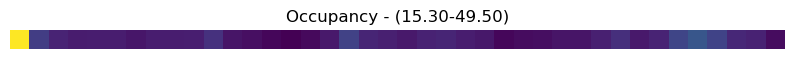

In [30]:
plot_heatmap(occ, title= create_heatmap_title('Occupancy', occ), figsize=(10, 6))

## Smoothing Kernel

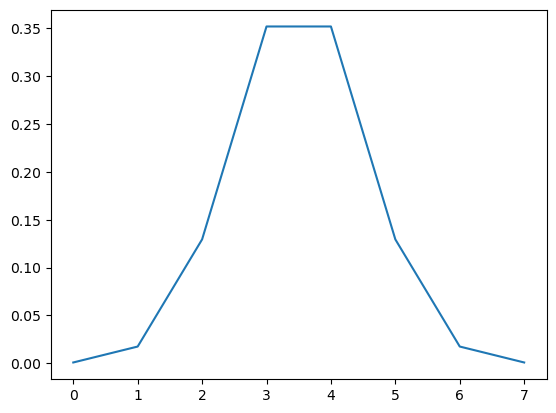

In [31]:
kernelSize = 8
g = signal.windows.gaussian(kernelSize, std=1)
g = g/np.sum(g)
plt.plot(g)

## Compute Mean Firing Rates

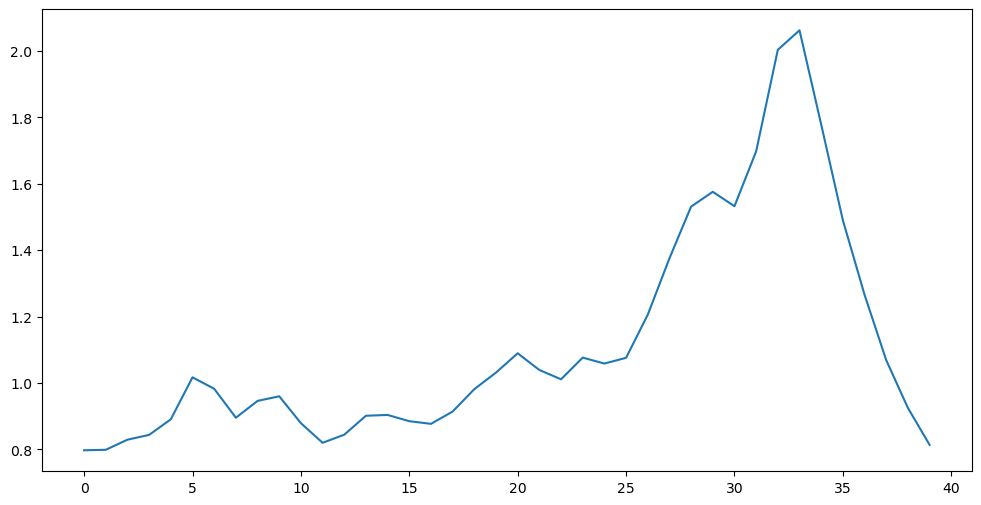

In [32]:
place_bins = compute_firing_rates(units_fr, pos_bin, occ, g, numBins, epochSize)
fig,ax = plt.subplots(1,1,figsize=(12,6))
plt.plot(place_bins)

## Compute Trial Occupancy

In [33]:
edges_trial = np.arange(0.5, 65, 1)  # 0.5:1:65 in MATLAB
trial_bin = np.array(behavioral_data['trialNum'])
trial_occupancy = compute_t_occupancy(trial_bin, pos_bin, edges_trial, edges_pos, epochSize)

In [34]:
trial_place_bins, trial_fr = compute_trial_firing_rates(trial_bin, pos_bin, units_fr, edges_trial, edges_pos, trial_occupancy, kernelSize, epochSize)

/Users/weijiazhang/code/AnalyzeTrain/notebooks/../code/utils.py:148: RuntimeWarning: invalid value encountered in divide
  trial_fr = trial_spikes/trial_occupancy


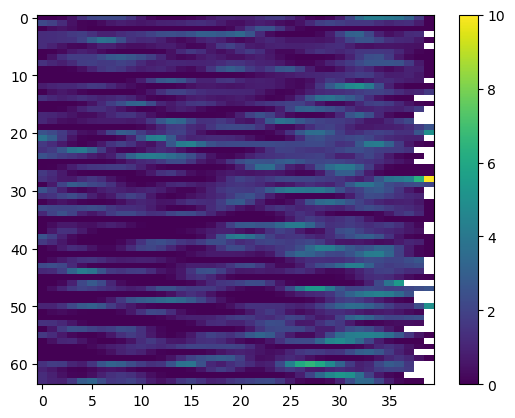

In [35]:
plt.imshow(trial_place_bins[:, :], aspect='auto')

plt.colorbar()
plt.show()

In [36]:
place_bins = np.nanmean(trial_place_bins,axis = 0)
place_sem = np.nanstd(trial_place_bins,axis = 0)/np.sqrt(trial_place_bins.shape[0])

fr_bins = np.nanmean(trial_fr,axis = 0)
fr_sem = np.nanstd(trial_fr,axis = 0)/np.sqrt(trial_fr.shape[0])

s_bins = np.linspace(0, 40, numBins+1)

## Statistical Analysis 

In [37]:
results = {}

In [38]:
# Compute mutual information of spiking and location
results['place_info'] = compute_spatial_information(place_bins, occ, normalize=False)
results['place_fr_info'] = compute_spatial_information(fr_bins, occ, normalize=False)
print(results['place_info'])

0.06257771714052537


## ANOVA

In [39]:
df = create_df_place(trial_place_bins[:,:-3])
results['place_anova']= fit_anova_place(df)
# Check the computed place F-value
print('The ANOVA place F-value is {:4.2f}'.format(results['place_anova']))

The ANOVA place F-value is 7.89


In [40]:
df_fr = create_df_place(trial_fr[:,:-3])
results['place_fr_anova']= fit_anova_place(df_fr)
# Check the computed place F-value
print('The ANOVA place F-value is {:4.2f}'.format(results['place_fr_anova']))

The ANOVA place F-value is 3.12


## Shuffle Analysis 

In [41]:
SURROGATES

{'approach': 'ISI', 'n_shuffles': 1000}

In [42]:
shuffles = circular_shuffle_unit_fr(units_fr, SURROGATES['n_shuffles'])

In [43]:
shuffles.shape

(1000, 7654)

In [44]:
surr_analyses = create_methods_list(METHODS)
surrs = {analysis : \
                    np.zeros(SURROGATES['n_shuffles']) for analysis in surr_analyses}


In [45]:
for ind, shuffle in enumerate(shuffles):
    surr_place_bins = compute_firing_rates(shuffle, pos_bin, occ, g, numBins, epochSize)
    surr_trial_place_bins, surr_trial_fr = compute_trial_firing_rates(trial_bin, pos_bin, shuffle, edges_trial, edges_pos, trial_occupancy, kernelSize, epochSize)
    surr_fr = np.nanmean(surr_trial_fr,axis = 0)
    #surr_place_bins= np.nanmean(surr_trial_place_bins,axis = 0)
    surrs['place_info'][ind] = compute_spatial_information(surr_place_bins, occ, normalize=False)
    surrs['place_anova'][ind] = fit_anova_place(create_df_place(surr_trial_place_bins))
    surrs['place_fr_info'][ind] = compute_spatial_information(surr_fr, occ, normalize=False)
    surrs['place_fr_anova'][ind] = fit_anova_place(create_df_place(surr_trial_fr))

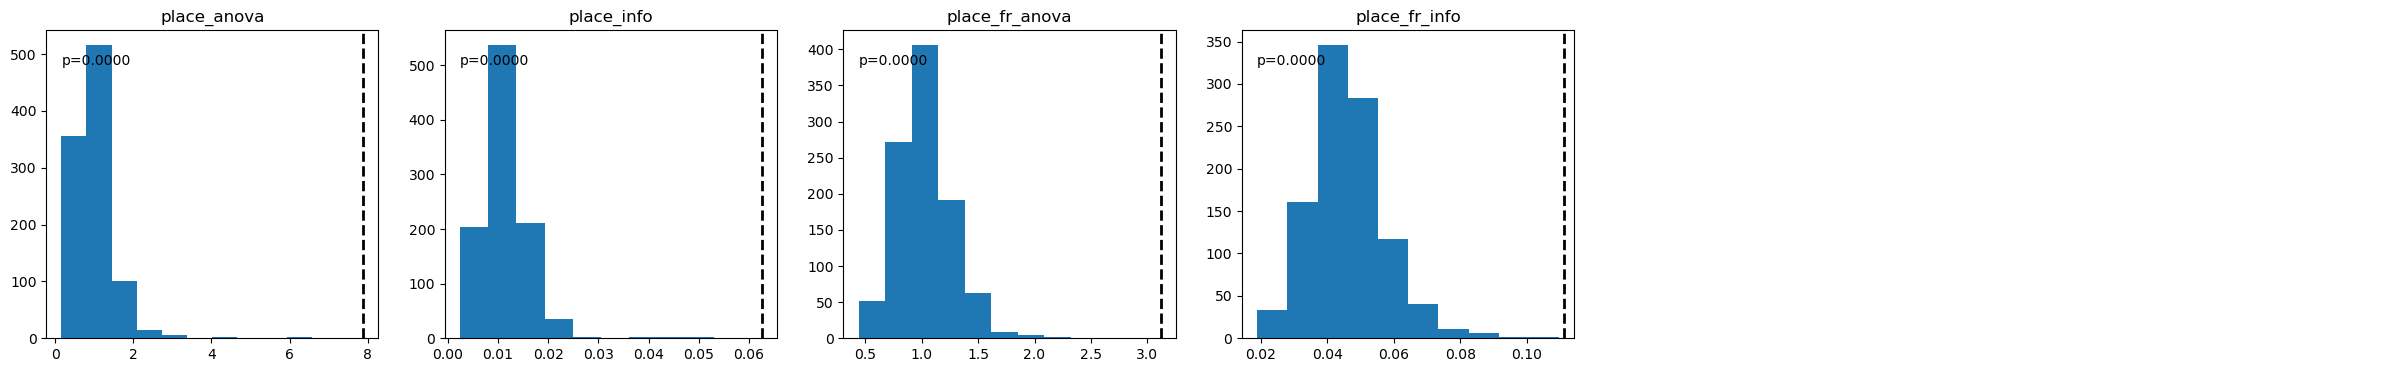

In [46]:
axes = make_axes(4, 6, figsize=(30, 4))
i = 0
for analysis in surr_analyses:
    results[analysis + '_surr_p_val'], results[analysis + '_surr_z_score'] = \
                        compute_surrogate_stats(results[analysis], surrs[analysis],title = analysis,plot = True, ax=axes[i])
    i = i+1

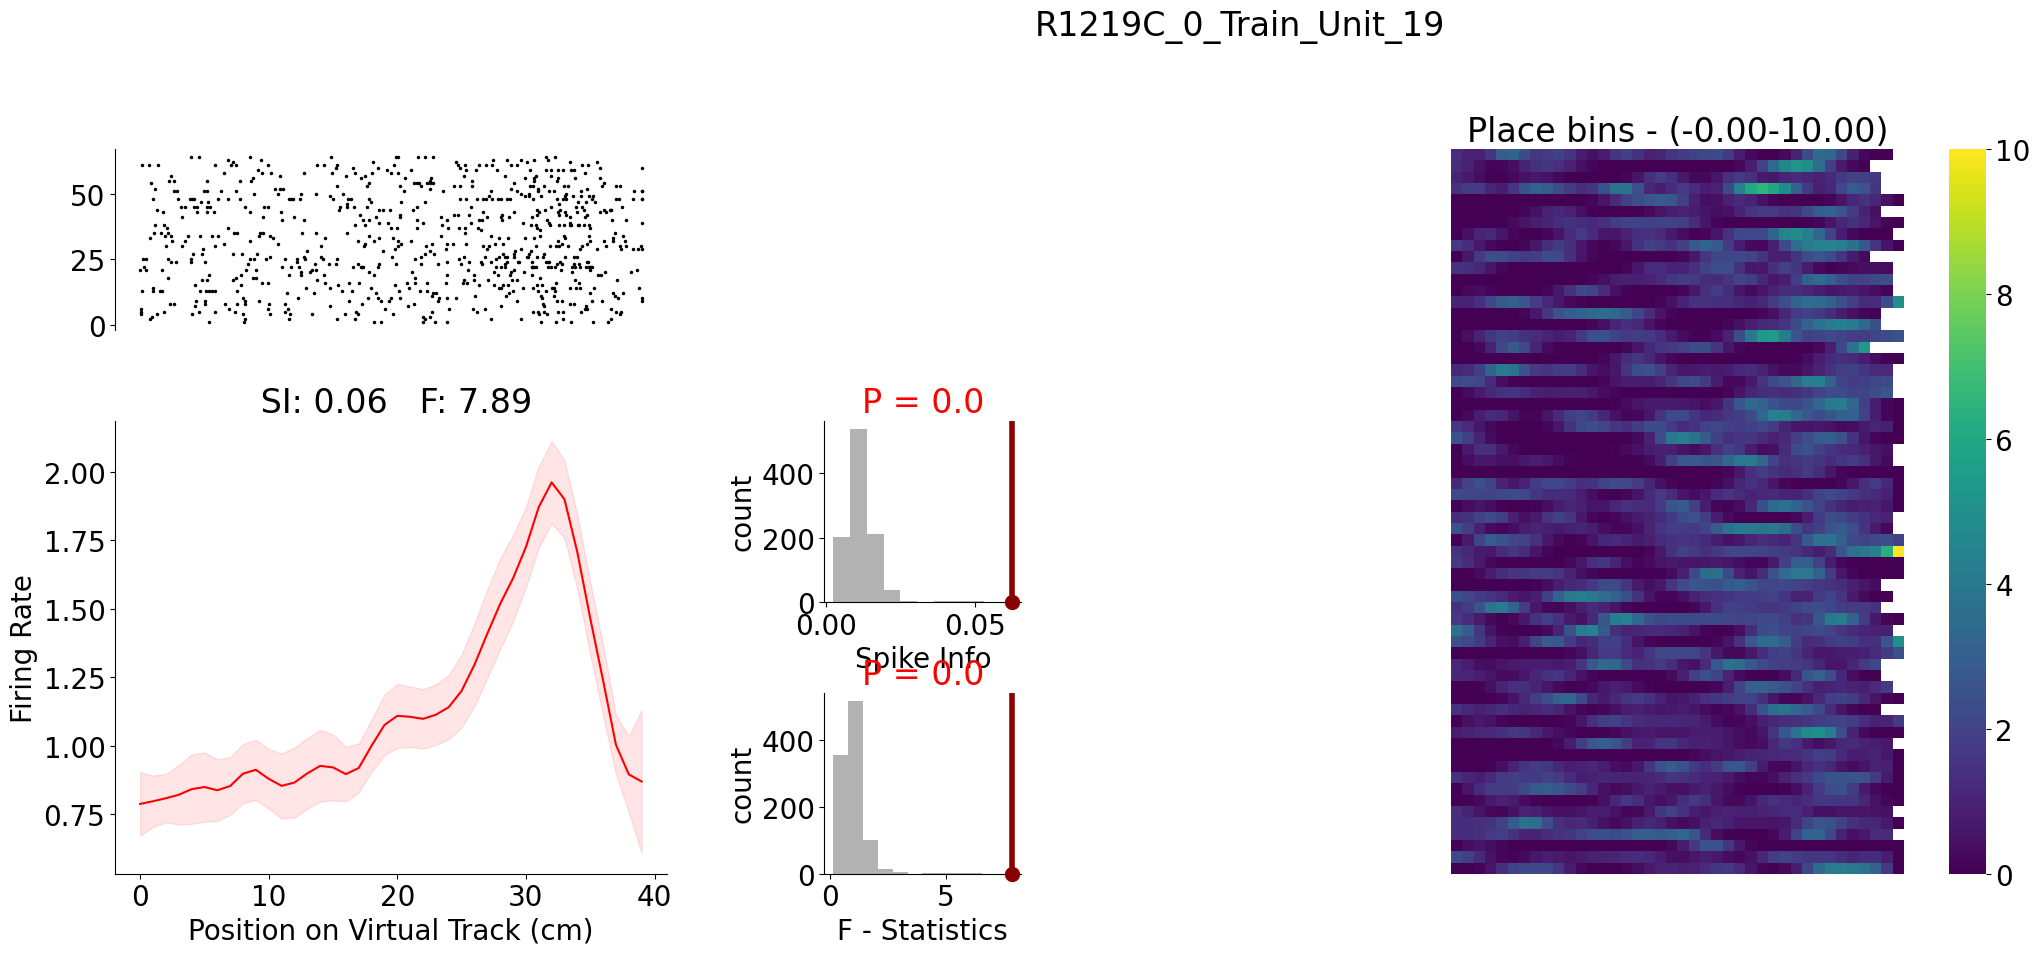

In [49]:
plt.rcParams.update({'font.size': 20})
grid = make_grid(6, 7, wspace=.8, hspace=.5, figsize=(30, 20)
                    ,title = 'R1219C_0_Train_Unit_19')

#plt.rcParams.update({'font.size': 25})
SI = results['place_info']
F = results['place_anova']
SI_fr = results['place_fr_info']
F_fr = results['place_fr_anova']

ax = get_grid_subplot(grid, slice(1,3), slice(0,2))
ax.plot( s_bins[:-1], place_bins, color = 'red', label='Mean Value')
ax.fill_between( s_bins[:-1], place_bins - place_sem, place_bins+ place_sem, color = 'red', alpha=0.1)
ax.set_xlabel('Position on Virtual Track (cm)')
ax.set_ylabel('Firing Rate')
ax.set_title(f' SI: {np.round(SI,2)}   F: {np.round(F,2)}')
drop_spines(['top','right'],ax = ax)

spikes_positions_trials = [[] for _ in range(64)]

# Create a figure
ax = get_grid_subplot(grid, slice(0,1), slice(0,2))

# For each trial
for num_trial in range(64):
    # Define trial indices
    trial_idx = [0, *trial_changes, len(spike_position)]
    
    # Extract spike positions for this trial
    if num_trial < len(trial_idx) - 1:
        trial_start = trial_idx[num_trial]
        trial_end = trial_idx[num_trial + 1]
        spikes_positions_trials[num_trial] = spike_position[trial_start:trial_end]
        
        # Plot spike positions for this trial
        if len(spikes_positions_trials[num_trial]) > 0:
            ax.plot(spikes_positions_trials[num_trial], 
                     [num_trial + 1] * len(spikes_positions_trials[num_trial]), 
                     'k.', markersize=3)
            
drop_spines(['top','right','bottom'],ax = ax)
ax.set_xticklabels([])
ax.set_xticks([])





ax = get_grid_subplot(grid, 1, 2)
P = results['place_info_surr_p_val']
plot_surrogates(surrs['place_info'], data_value=SI, p_value=None, title=f'P = {P}',
                                     title_color=color_pvalue(P),ax = ax,alpha = .6,color = 'grey')
add_vlines(SI , ax, color='darkred', linestyle='solid', linewidth=4)
ax.plot(SI , 0, 'o', zorder=10, clip_on=False, color='darkred', markersize=10)
ax.set_xlabel('Spike Info')
ax.set_ylabel('count')
drop_spines(['top', 'right'],ax)

ax = get_grid_subplot(grid, 2, 2)
P = results['place_anova_surr_p_val']
plot_surrogates(surrs['place_anova'], data_value=F, p_value=None ,title=f'P = {P}',
                                     title_color=color_pvalue(P),ax = ax,alpha = .6,color = 'grey')
add_vlines(F , ax, color='darkred', linestyle='solid', linewidth=4)
ax.plot(F , 0, 'o', zorder=10, clip_on=False, color='darkred', markersize=10)
ax.set_xlabel('F - Statistics')
ax.set_ylabel('count')
drop_spines(['top', 'right'],ax)



ax = get_grid_subplot(grid, slice(0,3), slice(3,6))
plot_heatmap(trial_place_bins, cbar=True,title= create_heatmap_title('Place bins', trial_place_bins), ax=ax)

